In [85]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from gensim.utils import simple_preprocess

# 1> Load the data using read_csv function from pandas package

In [86]:
data = pd.read_csv("C:/Users/sharv/Documents/Post Graduate Program In Data Science-PurdueSimpliLearn/Course4-NLP/Projects/train.csv")
data.head()

,id,comment_text,toxic
0,e617e2489abe9bca,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0
1,9250cf637294e09d,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0
2,ce1aa4592d5240ca,"Marya Dzmitruk was born in Minsk, Belarus in M...",0
3,48105766ff7f075b,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0
4,0543d4f82e5470b6,New Categories \r\n\r\nI honestly think that w...,0


In [87]:
data.toxic.value_counts(normalize=True)
# data is not balanced

0    0.9126
1    0.0874
Name: toxic, dtype: float64

In [88]:
data.comment_text.sample().values[0]

'"Palestine before 4000 BC"". \r\n\r\n"'

# 2> Get the comments into a list, for easy text cleanup and manipulation

In [90]:
data1 = data.comment_text.values
print(len(data1))
data1[:5]

5000


array(['"\r\n\r\n A barnstar for you! \r\n\r\n  The Defender of the Wiki Barnstar I like your edit on the Kayastha page. Lets form a solidarity group against those who malign the article and its subject matter. I propose the folloing name for the group.\r\n\r\nUnited intellectuals\' front of Kayastha ethinicty against racist or castist abuse (UIFKEARCA)   "',
       '"\r\n\r\nThis seems unbalanced.  whatever I have said about Mathsci, he has said far more extreme and unpleasant things about me (not to mention others), and with much greater frequency.  I\'m more than happy to reign myself in, if that\'s what you\'d like (ruth be told, I was just trying to get Mathsci to pay attention and stop being uncivil).  I would expect you to issue the same request to Mathsci.  \r\n\r\n If this is intentionally unbalanced (for whatever reason), please let me know, and I will voluntarily close this account and move on to other things.  I like wikipedia, and I have a lot to contribute in my own way, 

# 3> Cleanup:
- Using regular expressions, remove IP addresses
- Using regular expressions, remove URLs
- Normalize the casing
- Tokenize using word_tokenize from NLTK
- Remove stop words
- Remove punctuation

In [91]:
# removing IP addresses and numbers followed by "'s".

data2=[re.sub("((\d|\s)+\.)*","", sh) for sh in data1] # matches 0 or more of one or more digits followed by a period
data3=[re.sub("((\d|\s)+\'s)*","", sh) for sh in data2]
data3[124]

"About mass vandalism \r\n\r\nHello. This message is being sent to inform you that there is currently a discussion at Wikipedia:Administrators' noticeboard/Incidents regarding an issue with which you may have been involved.    Thank you. (talk)"

In [92]:
data4=[re.sub("\w+://\S+","", sh) for sh in data3] # remove URLs
#data4[1673]
#data4[4704]
data4[4702]

"\r\n\r\nHere he is, your decision to block me for one week or even more is fully justified as i abused a particular religion,nation and a user but my acts of putting those articles on the list of deletion were correct and justified, i have never removed a single para which has been cited alongside citations and further as i know India's History closely i can surely claim all those articles as myth and simply hoax. And the agreement of another Editor and Admin who too is from Europe but unlike you he based him opinion after going through the articles which are without A single source for many years, when even after searching so much on net we cant find a single source then the article qualifies for deletion but admin like you insist on such articles.You havent told me a single reason that why those articles should be maintained on wikipedia(apart from your personal rivalry against me)."

In [93]:
data5=[sh.lower() for sh in data4] # Normalize the casing
data5[4714]

"you love osama bin laden so don't deny!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!"

In [94]:
from nltk.tokenize import word_tokenize
data_tokens = [word_tokenize(sent) for sent in data5] # Tokenize using word_tokenize from NLTK
print(data_tokens[0])

['``', 'a', 'barnstar', 'for', 'you', '!', 'the', 'defender', 'of', 'the', 'wiki', 'barnstar', 'i', 'like', 'your', 'edit', 'on', 'the', 'kayastha', 'page', '.', 'lets', 'form', 'a', 'solidarity', 'group', 'against', 'those', 'who', 'malign', 'the', 'article', 'and', 'its', 'subject', 'matter', '.', 'i', 'propose', 'the', 'folloing', 'name', 'for', 'the', 'group', '.', 'united', 'intellectuals', "'", 'front', 'of', 'kayastha', 'ethinicty', 'against', 'racist', 'or', 'castist', 'abuse', '(', 'uifkearca', ')', '``']


In [95]:
from nltk.corpus import stopwords # removing stopwords and punctuations
from string import punctuation

stop_nltk = stopwords.words("english")
stop_punct = list(punctuation)

stop_punct.extend(['...','``',"''","..","$"])

stop_context = ['rt', 'amp','wikipedia','page','edit']

stop_final = stop_nltk + stop_punct + stop_context

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_final] for doc in texts]

data_words = remove_stopwords(data_tokens)
# print(data_words[0])
#print(data_words[4693])
#print(data_words[4639])
#print(data_words[4653])
#print(data_words[4751])
#print(data_words[4309])
print(data_words[826])

['xad', 'xad', 'yeah', 'revert', 'conformist']


# 4> Using a counter, find the top terms in the data.
- Can any of these be considered contextual stop words? 
- Words like “Wikipedia”, “page”, “edit” are examples of contextual stop words
- If yes, drop these from the data

In [96]:
from collections import Counter
term_list = []
for sh1 in data_words:
    term_list.extend(sh1)
    
res = Counter(term_list)
res.most_common(10)

[('article', 1735),
 ('talk', 1235),
 ('please', 1042),
 ('would', 1009),
 ('ass', 990),
 ('fuck', 908),
 ('one', 881),
 ('like', 845),
 ('also', 657),
 ('see', 632)]

In [97]:
# drop “Wikipedia”, “page”, “edit” from the data
del res['wikipedia'] 
del res['page'] 
del res['edit'] 
res.most_common(10)

[('article', 1735),
 ('talk', 1235),
 ('please', 1042),
 ('would', 1009),
 ('ass', 990),
 ('fuck', 908),
 ('one', 881),
 ('like', 845),
 ('also', 657),
 ('see', 632)]

In [102]:
# Join the tokens back into strings
data_clean = [" ".join(s) for s in data_words]
data_clean[0]

'barnstar defender wiki barnstar like kayastha lets form solidarity group malign article subject matter propose folloing name group united intellectuals front kayastha ethinicty racist castist abuse uifkearca'

# 5> Separate into train and test sets
- Use train-test method to divide your data into 2 sets: train and test
- Use a 70-30 split

In [106]:
X=data_clean
y=data.toxic.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

# 6> Use TF-IDF values for the terms as feature to get into a vector space model
- Import TF-IDF vectorizer from sklearn
- Instantiate with a maximum of 4000 terms in your vocabulary
- Fit and apply on the train set
- Apply on the test set

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer # creating Document Term Matrix
vectorizer = TfidfVectorizer(max_features = 4000)
len(X_train), len(X_test)

(3500, 1500)

In [108]:
X_train_bow = vectorizer.fit_transform(X_train)

X_test_bow = vectorizer.transform(X_test)

X_train_bow.shape, X_test_bow.shape

((3500, 4000), (1500, 4000))

In [109]:
print ("Num words:", len(vectorizer.get_feature_names()))

Num words: 4000


# 7> Model building: Support Vector Machine
- Instantiate SVC from sklearn with a linear kernel
- Fit on the train data
- Make predictions for the train and the test set

In [110]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear',random_state=8) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train_bow, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_bow)

# 8> Model evaluation: Accuracy, recall, and f1_score
- Report the accuracy on the train set
- Report the recall on the train set:decent, high, low?
- Get the f1_score on the train set

In [111]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labeled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9493333333333334
Precision: 0.9672131147540983
Recall: 0.44360902255639095


In [112]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1365    2]
 [  74   59]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1367
           1       0.97      0.44      0.61       133

    accuracy                           0.95      1500
   macro avg       0.96      0.72      0.79      1500
weighted avg       0.95      0.95      0.94      1500



# 9> Looks like you need to adjust the class imbalance, as the model seems to focus on the 0s
- Adjust the appropriate parameter in the SVC module

In [113]:
clf1 = svm.SVC(kernel='linear', 
            class_weight='balanced') # penalize
            #probability=True,
               #C=1.0)
 
clf1.fit(X_train_bow, y_train)
 
# Predict on training set
y_pred1 = clf1.predict(X_test_bow)
 
# Is our model still predicting just one class?
print( np.unique( y_pred1 ) )
# [0 1]
 
# How's our accuracy?
print( "Accuracy:",metrics.accuracy_score(y_test, y_pred1) )
print("Recall:",metrics.recall_score(y_test, y_pred))

[0 1]
Accuracy: 0.938
Recall: 0.44360902255639095


# 10> Train again with the adjustment and evaluate
- Train the model on the train set
- Evaluate the predictions on the validation set: accuracy, recall, f1_score

In [114]:
# Model Recall: what percentage of positive tuples are labeled as such?
print("Recall:",metrics.recall_score(y_test, y_pred1))

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred1))
print(classification_report(y_test,y_pred1))

Recall: 0.6390977443609023
[[1322   45]
 [  48   85]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1367
           1       0.65      0.64      0.65       133

    accuracy                           0.94      1500
   macro avg       0.81      0.80      0.81      1500
weighted avg       0.94      0.94      0.94      1500



# 11> Hyperparameter tuning
- Import GridSearch and StratifiedKFold (because of class imbalance)
- Provide the parameter grid to choose for ‘C’
- Use a balanced class weight while instantiating the Support Vector Classifier
# 12> Find the parameters with the best recall in cross validation
- Choose ‘recall’ as the metric for scoring

Grid Search Cross Validation We first need to define the grid:

In [167]:
C = [.0001, .001, .01, .1]   # C :-Penalty parameter C of the error term
degree = [3, 4, 5] # degree :- Degree of the polynomial kernel function.
gamma = [1, 10, 100] # gamma :- Kernel coefficient.
probability = [True] # kernel :- Specifies the kernel type to be used in the algorithm.

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly','linear'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf','linear'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
#svc = svm.SVC(random_state=8)
clf1 = svm.SVC(kernel='linear', 
            class_weight='balanced')

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
for train, test in skf.split(X_train, y_train):
    print('train -  {}   |   test -  {}'.format(np.bincount(y_train), np.bincount(y_test)))
    
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=clf1, 
                           param_grid= param_grid,
                           scoring='accuracy',
                           cv=skf,
                           #refit=False,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_bow, y_train)

train -  [3196  304]   |   test -  [1367  133]
train -  [3196  304]   |   test -  [1367  133]
train -  [3196  304]   |   test -  [1367  133]
train -  [3196  304]   |   test -  [1367  133]
train -  [3196  304]   |   test -  [1367  133]
Fitting 5 folds for each of 52 candidates, totalling 260 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed: 21.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(class_weight='balanced', kernel='linear'),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly', 'linear'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf', 'linear'],
                          'probability': [True]}],
             scoring='accuracy', verbose=1)

The best hyperparameters turn out to be:

In [169]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.9402857142857142


Let's save the model in best_svc:

In [170]:
best_svc = grid_search.best_estimator_
best_svc

SVC(C=0.1, class_weight='balanced', kernel='linear', probability=True)

We now know the best SVM model. Let's fit it and see how it performs: Model fit and performance Now, we can fit the model to our training data:

In [171]:
best_svc.fit(X_train_bow, y_train)
svc_pred = best_svc.predict(X_test_bow)

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

In [172]:
# Training accuracy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
print("The training accuracy is: ")
print(accuracy_score(y_train, best_svc.predict(X_train_bow)))
print("The training recall is: ")
print(recall_score(y_train, best_svc.predict(X_train_bow)))

The training accuracy is: 
0.9751428571428571
The training recall is: 
0.8947368421052632


In [173]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, svc_pred))
print("The test recall is: ")
print(recall_score(y_test, svc_pred))

The test accuracy is: 
0.9453333333333334
The test recall is: 
0.6390977443609023


In [174]:
# Classification report
print("Classification report")
print(classification_report(y_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1367
           1       0.71      0.64      0.67       133

    accuracy                           0.95      1500
   macro avg       0.84      0.81      0.82      1500
weighted avg       0.94      0.95      0.94      1500



In [175]:
from sklearn.metrics import recall_score
d = {
     'Model': 'SVM',
     'Training Set recall': recall_score(y_train, best_svc.predict(X_train_bow)),
     'Test Set recall': recall_score(y_test, best_svc.predict(X_test_bow))
}

df_models_svc = pd.DataFrame(d, index=[0])
df_models_svc

,Model,Training Set recall,Test Set recall
0,SVM,0.894737,0.639098


Training Recall value is better than Test Recall value.

# 13> What are the best parameters?

In [176]:
best_svc

SVC(C=0.1, class_weight='balanced', kernel='linear', probability=True)

# 14> Predict and evaluate using the best estimator
- Use best estimator from the grid search to make predictions on the test set
- What is the recall on the test set for the toxic comments?
- What is the f1_score?

In [177]:
print(classification_report(y_test,best_svc.predict(X_test_bow)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1367
           1       0.71      0.64      0.67       133

    accuracy                           0.95      1500
   macro avg       0.84      0.81      0.82      1500
weighted avg       0.94      0.95      0.94      1500



training data:



<AxesSubplot:>

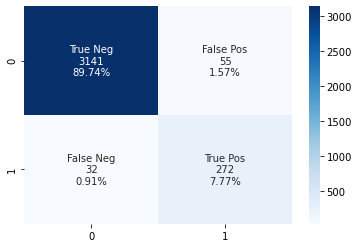

In [178]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm=confusion_matrix(y_train, best_svc.predict(X_train_bow))
#cmd = ConfusionMatrixDisplay(cm, display_labels=['toxic(0)','non-toxic(1)'])
print("training data:\n")
#cmd.plot()

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

testing data:



<AxesSubplot:>

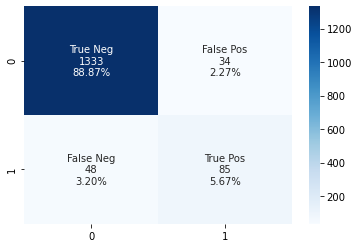

In [179]:
cm1=confusion_matrix(y_test,best_svc.predict(X_test_bow))
#cmd1 = ConfusionMatrixDisplay(cm1, display_labels=['toxic(0)','non-toxic(1)'])
print("testing data:\n")
#cmd1.plot()
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm1.flatten()/np.sum(cm1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm1, annot=labels, fmt='', cmap='Blues')

# 15> What are the most prominent terms in the toxic comments?
- Separate the comments from the test set that the model identified as toxic
- Make one large list of the terms
- Get the top 15 terms

In [192]:

X=data_clean
y=data.toxic.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=621)
from sklearn.feature_extraction.text import TfidfVectorizer # creating Document Term Matrix
vectorizer = TfidfVectorizer(max_features = 4000)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

x=X_train_bow.toarray()
best_svc.fit(x,y_train)
best_svc.score(x,y_train)

feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(best_svc.coef_[0], feature_names)) 
df=pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word'
df.sort_values(by='coefficient',ascending=True)
df.head(15)

,coefficient,word
0,-1.058102,article
1,-0.867129,also
2,-0.752324,one
3,-0.727663,please
4,-0.715148,utc
5,-0.622169,would
6,-0.619685,many
7,-0.582846,hi
8,-0.564963,thank
9,-0.555226,talk


In [193]:
x=X_test_bow .toarray()
best_svc.score(x,y_test)

feature_names = vectorizer.get_feature_names() 
coefs_with_fns = sorted(zip(best_svc.coef_[0], feature_names)) 
df=pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word'
df.sort_values(by='coefficient',ascending=False)
df.head(15)

,coefficient,word
0,-1.058102,article
1,-0.867129,also
2,-0.752324,one
3,-0.727663,please
4,-0.715148,utc
5,-0.622169,would
6,-0.619685,many
7,-0.582846,hi
8,-0.564963,thank
9,-0.555226,talk


In [183]:
res_df1 = pd.DataFrame({'word':X_test, 'toxic':y_test,'predictions':svc_pred})
res_df1

,word,toxic,predictions
0,agree asked add told likely deleted please tal...,0,0
1,figure else send message goes,0,0
2,hrwiki discussion concerning ip link,0,0
3,fundamental liberties derogated think freedom ...,0,0
4,sammy major lol communication studies,0,0
...,...,...,...
1495,speedy deletion sarah cudak tag placed sarah c...,0,0
1496,people care much immiagtion,0,1
1497,thus injured body fainting every step cries oh...,0,0
1498,dvyost dvyost one small nit pick paragraph min...,0,0


In [195]:
s=res_df1[res_df1.toxic==1]

In [185]:
s.head(15)

,word,toxic,predictions
9,think bully course bullies hate called anonymo...,1,0
13,back yeah know cahoots linux nutcase like pers...,1,1
24,seriously soon asi unbanened wll wreacfk every...,1,1
51,redneck shouldnt bad mouth nascar people think...,1,1
64,christian becaue jesus assyrian women tits ass...,1,0
65,fucking album cover fuck supposed know owns fu...,1,1
106,little douchebag gon na wish start,1,0
112,assume horrible nigger yuck,1,1
113,nigger nigger nigger nigger nigger nigger nigg...,1,1
119,neither mum sex,1,0
